I wanted to mix it up a little bit and create my own T-SNE using Keras.  Guess what?  It works!

In [3]:
from __future__ import print_function
import os
os.environ['TF_C_API_GRAPH_CONSTRUCTION']='0'
import warnings
warnings.filterwarnings("ignore")

#general packages
import time
import datetime
import gc

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.lines import Line2D
%matplotlib inline

#metrics
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error, roc_auc_score

from scipy.stats import norm, rankdata
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#modeling
from bayes_opt import BayesianOptimization
import lightgbm as lgb
import tensorflow as tf

import keras
from keras import regularizers
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add,PReLU, LSTM
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Reshape, Flatten, Conv2D, MaxPooling2D, Conv1D, MaxPool1D, GlobalMaxPooling1D
from keras.optimizers import SGD
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler

# module loading settings
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# reduce memory
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

Set working directory

In [5]:
print(os.listdir('../../kaggle/cis_fraud/input/'))
WDR='../../kaggle/cis_fraud/input/'

['diff_rolling_cust_id_10fold_2.csv', 'train_transaction.csv', 'time_series_attempt_01.csv', 'train_identity.csv', 'rolling_cust_id_2.csv', 'test_identity.csv', 'diff_rolling_cust_id_10fold.csv', 'agg_cust_id_trim.csv', 'diff_rolling_cust_id_1.csv', 'train_transaction.csv.zip', 'rolling_cust_id_3.csv', 'train_identity.csv.zip', 'dae_nn_00.csv', 'test_transaction.csv.zip', 'sample_submission.csv.zip', 'agg_cust_id_01.csv', 'rolling_cust_id_1.csv', 'sample_submission.csv', 'diff_rolling_cust_id_10fold_3.csv', 'diff_rolling_cust_id_3.csv', 'test_transaction.csv', 'test_identity.csv.zip']


Load data

In [6]:
train_transaction = reduce_mem_usage(pd.read_csv(WDR +'train_transaction.csv'))
print(train_transaction.shape)
test_transaction = reduce_mem_usage(pd.read_csv(WDR +'test_transaction.csv'))
print(test_transaction.shape)
train_identity = reduce_mem_usage(pd.read_csv(WDR +'train_identity.csv'))
print(train_identity.shape)
test_identity = reduce_mem_usage(pd.read_csv(WDR +'test_identity.csv'))
print(test_identity.shape)

Memory usage after optimization is: 542.35 MB
Decreased by 69.4%
(590540, 394)
Memory usage after optimization is: 472.59 MB
Decreased by 68.9%
(506691, 393)
Memory usage after optimization is: 25.86 MB
Decreased by 42.7%
(144233, 41)
Memory usage after optimization is: 25.44 MB
Decreased by 42.7%
(141907, 41)


Type formating

In [7]:
# Converting Strings to ints(or floats if nan in column)
for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_transaction[col] = train_transaction[col].map({'T':1, 'F':0})
    test_transaction[col]  = test_transaction[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_transaction[[col]], test_transaction[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_transaction[col] = train_transaction[col].map(col_encoded)
    test_transaction[col]  = test_transaction[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{'M0': 357789, 'M2': 122947, 'M1': 97306}


In [8]:
# Converting Strings to ints(or floats if nan in column)

for col in ['M1','M2','M3','M5','M6','M7','M8','M9']:
    train_transaction[col] = train_transaction[col].map({'T':1, 'F':0})
    test_transaction[col]  = test_transaction[col].map({'T':1, 'F':0})

for col in ['M4']:
    print('Encoding', col)
    temp_df = pd.concat([train_transaction[[col]], test_transaction[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_transaction[col] = train_transaction[col].map(col_encoded)
    test_transaction[col]  = test_transaction[col].map(col_encoded)
    print(col_encoded)

Encoding M4
{357789.0: 357789, 122947.0: 122947, 97306.0: 97306}


In [9]:
for col in ['card4', 'card6', 'ProductCD']:
    print('Encoding', col)
    temp_df = pd.concat([train_transaction[[col]], test_transaction[[col]]])
    col_encoded = temp_df[col].value_counts().to_dict()   
    train_transaction[col] = train_transaction[col].map(col_encoded)
    test_transaction[col]  = test_transaction[col].map(col_encoded)
    print(col_encoded)

Encoding card4
{'visa': 719649, 'mastercard': 347386, 'american express': 16009, 'discover': 9524}
Encoding card6
{'debit': 824959, 'credit': 267648, 'debit or credit': 30, 'charge card': 16}
Encoding ProductCD
{'W': 800657, 'C': 137785, 'R': 73346, 'H': 62397, 'S': 23046}


In [10]:
def minify_identity_df(df):

    df['id_12'] = df['id_12'].map({'Found':1, 'NotFound':0})
    df['id_15'] = df['id_15'].map({'New':2, 'Found':1, 'Unknown':0})
    df['id_16'] = df['id_16'].map({'Found':1, 'NotFound':0})

    df['id_23'] = df['id_23'].map({'TRANSPARENT':4, 'IP_PROXY':3, 'IP_PROXY:ANONYMOUS':2, 'IP_PROXY:HIDDEN':1})

    df['id_27'] = df['id_27'].map({'Found':1, 'NotFound':0})
    df['id_28'] = df['id_28'].map({'New':2, 'Found':1})

    df['id_29'] = df['id_29'].map({'Found':1, 'NotFound':0})

    df['id_35'] = df['id_35'].map({'T':1, 'F':0})
    df['id_36'] = df['id_36'].map({'T':1, 'F':0})
    df['id_37'] = df['id_37'].map({'T':1, 'F':0})
    df['id_38'] = df['id_38'].map({'T':1, 'F':0})

    df['id_34'] = df['id_34'].fillna(':0')
    df['id_34'] = df['id_34'].apply(lambda x: x.split(':')[1]).astype(np.int8)
    df['id_34'] = np.where(df['id_34']==0, np.nan, df['id_34'])
    
    df['id_33'] = df['id_33'].fillna('0x0')
    df['id_33_0'] = df['id_33'].apply(lambda x: x.split('x')[0]).astype(int)
    df['id_33_1'] = df['id_33'].apply(lambda x: x.split('x')[1]).astype(int)
    df['id_33'] = np.where(df['id_33']=='0x0', np.nan, df['id_33'])

    df['DeviceType'].map({'desktop':1, 'mobile':0})
    return df

train_identity = minify_identity_df(train_identity)
test_identity = minify_identity_df(test_identity)

for col in ['id_33']:
    train_identity[col] = train_identity[col].fillna('unseen_before_label')
    test_identity[col]  = test_identity[col].fillna('unseen_before_label')
    
    le = LabelEncoder()
    le.fit(list(train_identity[col])+list(test_identity[col]))
    train_identity[col] = le.transform(train_identity[col])
    test_identity[col]  = le.transform(test_identity[col])

In [11]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')
print("shape of train is ....."+str(train.shape))
print("shape of test is ....."+str(test.shape))

train = train[~train.index.duplicated()]
print("new shape of train is ....."+str(train.shape))

shape of train is .....(590540, 436)
shape of test is .....(506691, 435)
new shape of train is .....(590540, 436)


Define Card_ID

In [12]:
def corret_card_id(x):
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def define_indices(df):
    # create date column
    START_DATE = '2017-12-01'
    startdate = datetime.datetime.strptime(START_DATE, '%Y-%m-%d')
    df['date'] = df['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['dow'] = df['date'].dt.dayofweek
    df['day'] = df['date'].dt.day
    df['hour'] = df['date'].dt.hour
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    df['Card_ID'] = df[cards_cols].astype(str).sum(axis=1)
    
    # sort train data by Card_ID and then by transaction date 
    df= df.sort_values(['Card_ID', 'date'], ascending=[True, True])
    
    # small correction of the Card_ID
    df['Card_ID']=df['Card_ID'].apply(corret_card_id)
    
    # set indexes
    #df = df.reset_index()
    return df

In [13]:
train = define_indices(train)
test = define_indices(test)

Generate features

In [14]:
#generate features
features = train.loc[:, train.isnull().mean() < .05]
features = [f for f in features if f not in ['isFraud', 'TransactionID', 'TransactionDT', 'date', 'Card_ID']]

In [15]:
for var in ['Card_ID', 'day', 'dow', 'hour', 'month', 'year']:
    print(var)
    train['weight_' + var] = train.groupby([var])[var].transform('count')
    test['weight_' + var] = test.groupby([var])[var].transform('count')
    train['binary_' + var] = train['weight_' + var].apply(lambda x: 1 if x > 1 else 0) * train[var]
    test['binary_' + var] = test['weight_' + var].apply(lambda x: 1 if x > 1 else 0) * test[var]

Card_ID
day
dow
hour
month
year


In [16]:
df_original = pd.concat([train, test],axis=0,sort=False)
df_original = df_original.rename(columns={"isFraud": "target"})
print(df_original.shape)

(1097231, 455)


Drop missing

In [17]:
#drop columns
df = df_original.loc[:, df_original.isnull().mean() < .05]
df['target'] = df_original['target']
df['P_emaildomain'] = df_original['P_emaildomain']
df[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = df['P_emaildomain'].str.split('.', expand=True)
df.shape

(1097231, 135)

Aggregate features

In [18]:
def aggregate_transactions(df):
    for i in range(3, 21, 3):  
        
        df['time_lag{0}'.format(i)] = df.groupby('Card_ID')['date'].shift(-i)
        df['time_lag_between{0}'.format(i)] = pd.Series(delta.days for delta in (df['time_lag{0}'.format(i)] - df['date']))
        df['time_lag_between_smooth{0}'.format(i)] = df.groupby('Card_ID').apply(lambda x: x['time_lag_between{0}'.format(i)].ewm(span=i).mean()).reset_index(0,drop=True).values
        #df['time_lag_between_smooth_diff{0}'.format(i)] = df.groupby('Card_ID')['time_lag_between{0}'.format(i)].transform(pd.Series.diff)
        #df['time_lag_between_smooth_diff_rolling{0}'.format(i)] = df.groupby('Card_ID')['time_lag_between{0}'.format(i)].rolling(i).mean().reset_index(0,drop=True)

        df['transactions_count'] = df.groupby('Card_ID').size().reset_index(0,drop=True)
        #df['tamt_lag{0}'.format(i)] = df.groupby('Card_ID')['TransactionAmt'].shift(-i)
        df['tamt_lag_smooth{0}'.format(i)] = df.groupby('Card_ID').apply(lambda x: x['TransactionAmt'].ewm(span=i).mean()).reset_index(0,drop=True).values
        #df['tamt_lag_smooth_diff{0}'.format(i)] = df.groupby('Card_ID')['TransactionAmt'].transform(pd.Series.diff)
        #df['tamt_lag_smooth_diff_rolling{0}'.format(i)] = df.groupby('Card_ID')['TransactionAmt'].rolling(i).mean().reset_index(0,drop=True)
        
        agg_func = {
            #'tamt_lag{0}'.format(i): ['mean', 'max', 'min', 'std'],
            'tamt_lag_smooth{0}'.format(i): ['mean', 'max', 'min', 'std'],
            #'tamt_lag_smooth_diff{0}'.format(i): ['mean', 'max', 'min', 'std'],
            #'tamt_lag_smooth_diff_rolling{0}'.format(i): ['mean', 'max', 'min', 'std'],
            
            #'time_lag_between{0}'.format(i): ['mean', 'max', 'min', 'std'],
            'time_lag_between_smooth{0}'.format(i): ['mean', 'max', 'min', 'std'],
            #'time_lag_between_smooth_diff{0}'.format(i): ['mean', 'max', 'min', 'std'],
            #'time_lag_between_smooth_diff_rolling{0}'.format(i): ['mean', 'max', 'min', 'std']
            }
                                    
        agg_history = df.groupby(['Card_ID']).agg(agg_func)
        agg_history.columns = ['_'.join(col).strip() for col in agg_history.columns.values]
        agg_history.reset_index(inplace=True)
        agg_history.columns = ['hist_' + c if c != 'Card_ID' else c for c in agg_history.columns]
        agg_history = agg_history.replace(np.nan, 0)
        
    return agg_history

In [19]:
agg_history = aggregate_transactions(df)
df = pd.merge(df, agg_history, on='Card_ID', how='left')
df.shape

(1097231, 168)

Clean up workspace

In [20]:
del df_original, agg_history, train, test, test_identity, train_identity, train_transaction, test_transaction, temp_df
gc.collect()
%whos DataFrame

Variable   Type         Data/Info
---------------------------------
df         DataFrame             TransactionID  T<...>97231 rows x 168 columns]


Encode data

In [21]:
#Select features
features = [f for f in df if f not in ['target', 'TransactionID', 'TransactionDT', 'date', 'Card_ID']]
df_numerics_only = [col for col in df[features].select_dtypes(include=[np.number])]
df_categorical_only = [col for col in df[features].columns if col not in df_numerics_only]

In [22]:
def encoder(df, numerics_only, categorical_only):
    
    #Numeric Encoding
    for col in numerics_only:
        df[col] = (df[col].fillna(-99))
        df[col] = df[col].astype(float)
        df[col] = df[col].fillna(df[col].mean())
        
    # Label Encoding
    for col in categorical_only:
        df[col] = df[col].fillna(df[col].mode()[0])
        df[col] = df[col].astype('category')
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df[col].values))
        df[col] = lbl.transform(list(df[col].values))
        
    return df

In [23]:
df[features] = encoder(df[features], df_numerics_only, df_categorical_only)

Scale data

In [24]:
#Guass transformation
from scipy.special import erfinv
for col in df_numerics_only:
    values = sorted(set(df[col]))
    # Because erfinv(1) is inf, we shrink the range into (-0.9, 0.9)
    f = pd.Series(np.linspace(-0.9, 0.9, len(values)), index=values)
    f = np.sqrt(2) * erfinv(f)
    f -= f.mean()
    df[col] = df[col].map(f)
    df[col] = df[col].round(4)

Define T-SNE

In [25]:
#define uniform batch size
from fractions import gcd
gcb = []

for i in range(32,128):
    gcb.append(gcd(df[df_numerics_only].shape[0],i))
    
gcb.sort(reverse=True)
gcb = [nom for nom in gcb if nom != df[df_numerics_only].shape[0]]
batch = gcb[0]
print(batch)

79


In [31]:
#set params
len_input_columns, len_data = df[df_numerics_only].shape[1], df[df_numerics_only].shape[0]
kernel_initializer=keras.initializers.lecun_normal()
NUM_GPUS=2
learning_rate = 0.001
nb_epoch = int(100)
dcy = learning_rate / nb_epoch

In [26]:
#create probability function
def Hbeta(D, beta):
    P = np.exp(-D * beta)
    sumP = np.sum(P)
    H = np.log(sumP) + beta * np.sum(np.multiply(D, P)) / sumP
    P = P / sumP
    return H, P

def x2p(X, u=15, tol=1e-4, print_iter=500, max_tries=50, verbose=0):
    # Initialize some variables
    n = X.shape[0]                     # number of instances
    P = np.zeros((n, n))               # empty probability matrix
    beta = np.ones(n)                  # empty precision vector
    logU = np.log(u)                   # log of perplexity (= entropy)
    
    # Compute pairwise distances
    if verbose > 0: print('Computing pairwise distances...')
    sum_X = np.sum(np.square(X), axis=1)
    # note: translating sum_X' from matlab to numpy means using reshape to add a dimension
    D = sum_X + sum_X[:,None] + -2 * X.dot(X.T)

    # Run over all datapoints
    if verbose > 0: print('Computing P-values...')
    for i in range(n):
        
        if verbose > 1 and print_iter and i % print_iter == 0:
            print('Computed P-values {} of {} datapoints...'.format(i, n))
        
        # Set minimum and maximum values for precision
        betamin = float('-inf')
        betamax = float('+inf')
        
        # Compute the Gaussian kernel and entropy for the current precision
        indices = np.concatenate((np.arange(0, i), np.arange(i + 1, n)))
        Di = D[i, indices]
        H, thisP = Hbeta(Di, beta[i])
        
        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while abs(Hdiff) > tol and tries < max_tries:
            
            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i]
                if np.isinf(betamax):
                    beta[i] *= 2
                else:
                    beta[i] = (beta[i] + betamax) / 2
            else:
                betamax = beta[i]
                if np.isinf(betamin):
                    beta[i] /= 2
                else:
                    beta[i] = (beta[i] + betamin) / 2
            
            # Recompute the values
            H, thisP = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1
        
        # Set the final row of P
        P[i, indices] = thisP
        
    if verbose > 0: 
        print('Mean value of sigma: {}'.format(np.mean(np.sqrt(1 / beta))))
        print('Minimum value of sigma: {}'.format(np.min(np.sqrt(1 / beta))))
        print('Maximum value of sigma: {}'.format(np.max(np.sqrt(1 / beta))))
    
    return P, beta

def compute_joint_probabilities(samples, batch_size=5000, d=2, perplexity=30, tol=1e-5, verbose=0):
    v = d - 1
    
    # Initialize some variables
    n = samples.shape[0]
    batch_size = min(batch_size, n)
    
    # Precompute joint probabilities for all batches
    if verbose > 0: print('Precomputing P-values...')
    batch_count = int(n / batch_size)
    P = np.zeros((batch_count, batch_size, batch_size))
    for i, start in enumerate(range(0, n - batch_size + 1, batch_size)):   
        curX = samples[start:start+batch_size]                   # select batch
        P[i], beta = x2p(curX, perplexity, tol, verbose=verbose) # compute affinities using fixed perplexity
        P[i][np.isnan(P[i])] = 0                                 # make sure we don't have NaN's
        P[i] = (P[i] + P[i].T) # / 2                             # make symmetric
        P[i] = P[i] / P[i].sum()                                 # obtain estimation of joint probabilities
        P[i] = np.maximum(P[i], np.finfo(P[i].dtype).eps)

    return P

In [27]:
# P is the joint probabilities for this batch (Keras loss functions call this y_true)
# activations is the low-dimensional output (Keras loss functions call this y_pred)
def tsne(P, activations):
    d = int(model.get_layer('Output').get_output_at(0).get_shape().as_list()[1])
    #d = 5
    n = batch
    v = d - 1.
    eps = K.variable(10e-15) # needs to be at least 10e-8 to get anything after Q /= K.sum(Q)
    sum_act = K.sum(K.square(activations), axis=1)
    Q = K.reshape(sum_act, [-1, 1]) + -2 * K.dot(activations, K.transpose(activations))
    Q = (sum_act + Q) / v
    Q = K.pow(1 + Q, -(v + 1) / 2)
    Q *= K.variable(1 - np.eye(n))
    Q /= K.sum(Q)
    Q = K.maximum(Q, eps)
    C = K.log((P + eps) / (Q + eps))
    C = K.sum(P * C)
    return C

In [28]:
from keras.callbacks import LearningRateScheduler
import math
from math import exp

def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate
#lrate = LearningRateScheduler(step_decay)
        
#def exp_decay(epoch):
#    initial_lrate = 0.1
#    k = 0.1
#    t = epoch
#    lrate = initial_lrate * exp(-k*t)
#    return lrate
#lrate = LearningRateScheduler(exp_decay)

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
#        self.lr.append(exp_decay(len(self.losses)))
        self.lr.append(step_decay(len(self.losses)))

Build model

In [33]:
#build model
model = Sequential()
model.add(Dense(units=len_input_columns, dtype='float32', name='input', input_shape=(len_input_columns,)))
model.add(Dense(units=500, activation='relu', dtype='float32', name='Hidden1', kernel_initializer=kernel_initializer))
model.add(Dense(units=500, activation='relu', dtype='float32', name='Hidden2', kernel_initializer=kernel_initializer))
model.add(Dense(units=2000, activation='relu', dtype='float32', name='Hidden3', kernel_initializer=kernel_initializer))
model.add(Dense(units=5, activation='linear', dtype='float32', name='Output', kernel_initializer=kernel_initializer))

multi_gpu_model = keras.utils.multi_gpu_model(model, gpus=NUM_GPUS)
model_opt = keras.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=dcy, amsgrad=False)
multi_gpu_model.compile(metrics=['accuracy'],loss=tsne, optimizer=model_opt)

print("MULTI GPU MODEL")
print(multi_gpu_model.summary())

Instructions for updating:
Colocations handled automatically by placer.
MULTI GPU MODEL
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_input (InputLayer)        (None, 152)          0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 152)          0           input_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 152)          0           input_input[0][0]                
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5)            1362261     lambda_1[0][0]                   
                     

In [34]:
#define callbacks
cp = ModelCheckpoint(filepath="tsne_0.h5",save_best_only=True,verbose=0)
cpnn = ModelCheckpoint(filepath="ae_0.h5",save_best_only=True,verbose=0)
tb = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=True)
rl = tf.keras.callbacks.ReduceLROnPlateau(monitor='acc', patience=1, verbose=1)
es = tf.keras.callbacks.EarlyStopping(monitor='acc', patience=5, verbose=1)
loss_history = LossHistory()
lrate = LearningRateScheduler(step_decay)

In [ ]:
#compute probability
P = compute_joint_probabilities(df[df_numerics_only].values, batch_size=batch, d = int(model.get_layer('Output').get_output_at(0).get_shape().as_list()[1]), verbose=0)
Y_train = P.reshape(df[df_numerics_only].shape[0], -1)
Y_train.shape

Train T-SNE

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1097231/1097231 [==============================] - 154s 140us/step - loss: 23.6631 - acc: 0.0101
Epoch 2/100
1097231/1097231 [==============================] - 152s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 3/100
1097231/1097231 [==============================] - 152s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 4/100
1097231/1097231 [==============================] - 151s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 5/100
1097231/1097231 [==============================] - 151s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 6/100
1097231/1097231 [==============================] - 151s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 7/100
1097231/1097231 [==============================] - 151s 138us/step - loss: 23.6648 - acc: 0.0101
Epoch 00007: early stopping


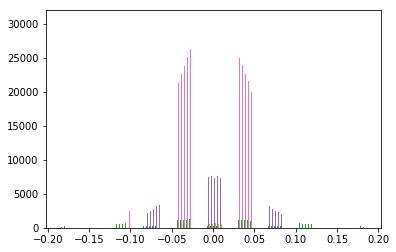

In [31]:
#train model
from math import ceil
multi_process_workers = 18
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    multi_gpu_model.fit(df[df_numerics_only].values, Y_train, batch_size=batch, shuffle=False, epochs=nb_epoch,
    verbose=1,
    callbacks=[cpnn,tb,es,loss_history,lrate])
sess.close() 

plt.hist(multi_gpu_model.get_weights(), bins = 100)
plt.show()

In [32]:
#join data
reconstruction = pd.DataFrame(multi_gpu_model.predict(df[df_numerics_only].values))
reconstruction = reconstruction.reset_index(drop=True)

df = df.reset_index(drop=True)
df = pd.concat([df, reconstruction], axis=1)
df = df.rename(index=str, columns={0: "tsne_0", 1: "tsne_1", 2: "tsne_2", 3: "tsne_3", 4: "tsne_4",})

Plot reconstruction

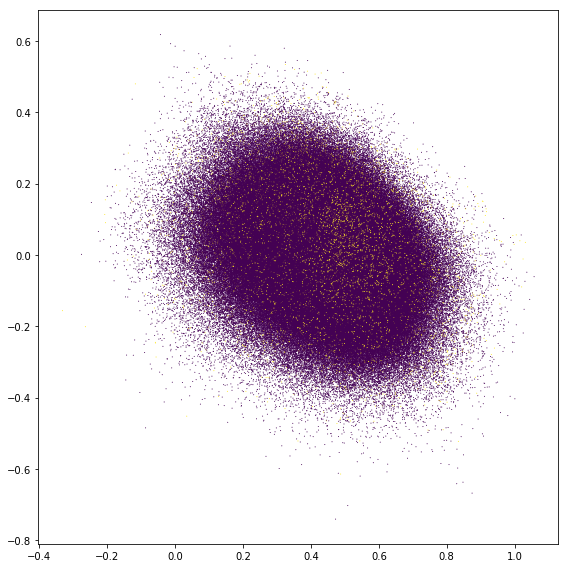

In [33]:
def plot_model(embedding, labels):
    fig = plt.figure(figsize=(8,8))
    plt.scatter(embedding[:,0], embedding[:,1], marker='o', s=1, edgecolor='', c=labels)
    fig.tight_layout()
    
from matplotlib.lines import Line2D
def plot_differences(embedding, actual, lim=1000):
    fig = plt.figure(figsize=(12,12))
    ax = fig.gca()
    for a, b in zip(embedding, actual)[:lim]:
        ax.add_line(Line2D((a[0], b[0]), (a[1], b[1]), linewidth=1))
    ax.autoscale_view()
    plt.show()
    
plot_model(reconstruction.values, df['target'].values)

Generate more features

In [34]:
for feature in df.filter(like='tsne').columns:
    df['mean_'+feature] = (df[feature].mean()-df[feature])
    df['zscore_'+feature] = (df[feature] - df[feature].mean())/df[feature].std(ddof=0)
    df['sq_'+feature] = (df[feature])**2
    df['sqrt_'+feature] = np.abs(df[feature])**(1/2)
    
    #these need work
    #df['cp_'+feature] = pd.DataFrame(rankdata(df[feature]))
    #df['cnp_'+feature] = pd.DataFrame((norm.cdf(df[feature])))
    #df['zscorecountarctan'+feature]=(np.arctan(df['weight_'+features])2/np.pi)df['zscore_'+feature]
    #df['zscorecount' +feature] = df['zscore_'+feature] * ((df['weight_'+feature]-df['weight_'+feature].min())/((df['weight_'+feature].max()-df['weight_'+feature].min())*8+1))

Define LGBM Grid

In [35]:
#Select features
features = [f for f in df if f not in ['target', 'TransactionID', 'TransactionDT', 'date', 'Card_ID']]
df_numerics_only = [col for col in df[features].select_dtypes(include=[np.number])]
df_categorical_only = [col for col in df[features].columns if col not in df_numerics_only]
training_features = [f for f in df[features] if f not in ['P_emaildomain_2', 'P_emaildomain_3',
                    'P_emaildomain', 'card1', 'card2', 'card3', 'card5', 'addr1','C13', 'D1']]

In [36]:
#encode the data
df[features] = encoder(df[features], df_numerics_only, df_categorical_only)
train = df[df['target'].notnull()]
train['target'] = train['target'].astype(int)
test = df[df['target'].isnull()]

#check data
print(df.shape)
print(train.shape)
print(test.shape)
print(df.head(5))
print(train.head(5))

(1097231, 193)
(590540, 193)
(506691, 193)
   TransactionID  TransactionDT  TransactionAmt  ProductCD   card1   card2  \
0        3169988        4050851         -0.6244     1.6449  0.0387 -1.4643   
1        3328484        8421815         -0.5072     0.5978  0.0391  1.1224   
2        3337343        8634882         -1.0597     0.5978  0.0391  1.1224   
3        3337365        8635215         -0.8058     0.5978  0.0391  1.1224   
4        3337822        8642405         -0.8058     0.5978  0.0391  1.1224   

    card3   card4   card5   card6  ...  sq_tsne_2  sqrt_tsne_2  mean_tsne_3  \
0 -0.2660  0.5978 -0.9645  1.6449  ...   0.037956     0.441389    -0.022163   
1 -0.6864  1.6449  1.1663  1.6449  ...   0.122209     0.591256    -0.020206   
2 -0.6864  1.6449  1.1663  1.6449  ...   0.042560     0.454203    -0.155496   
3 -0.6864  1.6449  1.1663  1.6449  ...   0.073647     0.520941    -0.050301   
4 -0.6864  1.6449  1.1663  1.6449  ...   0.006089     0.279341    -0.029454   

   zscore_tsn

Define grid architecture

In [56]:
#set archtype
nb_folds = 4
runs_per_fold = 3 #bagging on each fold
nb_epoch = int(10000)
kfolds = StratifiedKFold(n_splits=nb_folds, shuffle=True, random_state=42)
#kfolds = TimeSeriesSplit(n_splits=nb_folds)
#kfolds = BlockingTimeSeriesSplit(n_splits=nb_folds)

#create empty dataframes
features_importance = pd.DataFrame({'Feature':[], 'Importance':[], 'Fold':[], 'Aug':[]})
oof = np.zeros(shape=(np.shape(train)[0], 1))
predict = np.zeros(shape=(np.shape(test)[0], 1))
predictions = np.zeros(shape=(np.shape(test)[0], nb_folds))
oof_lgbm = np.zeros(len(train))
avg_roc = np.zeros(1)
cv_roc = []

In [57]:
# Bounded region of parameter space
bounds_LGB = {
    'num_leaves': (2, 300), 
    'min_data_in_leaf': (2, 300),
    'bagging_fraction' : (0.1,0.9),
    'feature_fraction' : (0.1,0.9),
    'learning_rate': (0.003, 0.01),
    'min_child_weight': (0.00001, 0.01),   
    'min_child_samples':(100, 500), 
    'subsample': (0.2, 0.8),
    'colsample_bytree': (0.4, 0.6), 
    'reg_alpha': (0, 2), 
    'reg_lambda': (0, 2),
    'max_depth':(1,100)
    }

Let's Create the functions we will use for the grid

In [58]:
# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.contrib.metrics.streaming_auc(y_pred, y_true)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value
    
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def gini_normalizedc(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [59]:
def augment(x,y,t=2):
    xs,xn = [],[]
    for i in range(t):
        mask = y>0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xs.append(x1)

    for i in range(t//2):
        mask = y==0
        x1 = x[mask].copy()
        ids = np.arange(x1.shape[0])
        for c in range(x1.shape[1]):
            np.random.shuffle(ids)
            x1[:,c] = x1[ids][:,c]
        xn.append(x1)

    xs = np.vstack(xs)
    xn = np.vstack(xn)
    ys = np.ones(xs.shape[0])
    yn = np.zeros(xn.shape[0])
    x = np.vstack([x,xs,xn])
    y = np.concatenate([y,ys,yn])
    return x,y

In [60]:
def LGB_Grid(trn_data, dev_data, X_valid,  y_valid):
    #base LGBM 
    """Apply Bayesian Optimization to LGBM parameters."""
    
    init_points = 5
    n_iter = 5
    score = np.zeros(1)
    num_round = 100
    oof_lgb = np.zeros(len(X_valid))
    
    def LGB_bayesian(
        learning_rate,
        num_leaves, 
        bagging_fraction,
        feature_fraction,
        min_child_samples, 
        min_child_weight,
        subsample, 
        min_data_in_leaf,
        max_depth,
        colsample_bytree,
        reg_alpha,
        reg_lambda
         ):

        # LightGBM expects next three parameters need to be integer. 
        num_leaves = int(num_leaves)
        min_data_in_leaf = int(min_data_in_leaf)
        max_depth = int(max_depth)

        assert type(num_leaves) == int
        assert type(min_data_in_leaf) == int
        assert type(max_depth) == int

        param = {
                  'num_leaves': num_leaves, 
                  'min_child_samples': min_child_samples, 
                  'min_data_in_leaf': min_data_in_leaf,
                  'min_child_weight': min_child_weight,
                  'bagging_fraction' : bagging_fraction,
                  'feature_fraction' : feature_fraction,
                  'learning_rate' : learning_rate,
                  'subsample': subsample, 
                  'max_depth': max_depth,
                  'colsample_bytree': colsample_bytree,
                  'reg_alpha': reg_alpha,
                  'reg_lambda': reg_lambda,
                  'objective': 'binary',
                  'save_binary': True,
                  'seed': 420,
                  'feature_fraction_seed': 420,
                  'bagging_seed': 420,
                  'drop_seed': 420,
                  'data_random_seed': 420,
                  'boosting_type': 'gbdt',
                  'verbose': 1,
                  'is_unbalance': True,
                  'boost_from_average': False,
                  'metric':'auc'
                  }   

        clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, dev_data], verbose_eval=False, early_stopping_rounds=200)
        oof_lgb = clf.predict(X_valid, num_iteration=clf.best_iteration)
        score = gini_normalizedc(y_valid, oof_lgb)
        #score = auc_roc(y_valid, oof_lgb)
        #print(score)
        auc_score = score
        return auc_score
    
    LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB)
    print(LGB_BO.space.keys)
    
    print('-' * 130)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)
        
    print(LGB_BO.max['target'])
    return(LGB_BO.max['params'])

Run the grid!

In [61]:
#run grid
for fold_, (trn_idx, dev_idx) in enumerate(kfolds.split(train[training_features], train['target'])):  
    
    #manipulate data
    #train_df = pd.concat([aggregate_transactions(time_train.iloc[trn_idx]), aggregate_transactions(time_train.iloc[dev_idx])])
    trn = train[training_features].iloc[trn_idx]
    dev = train[training_features].iloc[dev_idx]
    
    #grab targets
    trn_target = train['target'].iloc[trn_idx]
    dev_target = train['target'].iloc[dev_idx]
    
    #encode data    
    #trn[encoder_features] = encoder(trn)
    #dev[encoder_features] = encoder(dev)
    
    #create train/dev splits
    #trn_data = lgb.Dataset(trn, label=trn_target)
    #dev_data = lgb.Dataset(dev, label=dev_target)
    X_train, y_train = trn, trn_target
    X_valid, y_valid = dev, dev_target
    
    #upsampling adapted from kernel: 
    #https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283
    pos = (pd.Series(y_train == 1))
    
    # Add positive examples
    X_train = pd.concat([X_train, X_train.loc[pos]], axis=0)
    y_train = pd.concat([y_train, y_train.loc[pos]], axis=0)
    
    # Shuffle data
    idx = np.arange(len(X_train))
    np.random.shuffle(idx)
    X_train = X_train.iloc[idx]
    y_train = y_train.iloc[idx]
 
    #run augmentation
    predictions_lgb = np.zeros(len(test))
    roc = np.zeros(1)
    p_valid,yp = 0,0
    
    for i in range(runs_per_fold):
        print('-')
        print("Fold {}".format(fold_ + 1))
        print("Augment {}".format(i + 1))
        X_t, y_t = augment(X_train.values, y_train.values)
        X_t = pd.DataFrame(X_t)
        X_t = X_t.add_prefix('var_')
    
        #run probability grid
        trn_data = lgb.Dataset(X_t, label=y_t)
        dev_data = lgb.Dataset(X_valid, label=y_valid)
        best_param =  LGB_Grid(trn_data, dev_data, X_valid,  y_valid)

        param_lgb = {
            'min_data_in_leaf': int(best_param['min_data_in_leaf']), 
            'num_leaves': int(best_param['num_leaves']), 
            'learning_rate': best_param['learning_rate'],
            'min_child_weight': best_param['min_child_weight'],
            'colsample_bytree' : best_param['colsample_bytree'],
            'bagging_fraction': best_param['bagging_fraction'], 
            'min_child_samples': best_param['min_child_samples'],
            'subsample': best_param['subsample'],
            'reg_lambda': best_param['reg_lambda'],
            'reg_alpha': best_param['reg_alpha'],
            'max_depth': int(best_param['max_depth']), 
            'objective': 'binary',
            'save_binary': True,
            'seed': 420,
            'feature_fraction_seed': 420,
            'bagging_seed': 420,
            'drop_seed': 420,
            'data_random_seed': 420,
            'boosting_type': 'gbdt',
            'verbose': 1,
            'is_unbalance': True,
            'boost_from_average': False,
            'metric':'auc'
        }
        #train best model and predict
        clf = lgb.train(param_lgb, trn_data, nb_epoch, valid_sets = [trn_data, dev_data], verbose_eval=100, early_stopping_rounds=200)
        oof_lgbm[dev_idx] += clf.predict(X_valid, num_iteration=clf.best_iteration) / runs_per_fold
        predictions[:, fold_] += clf.predict(test[training_features], num_iteration=clf.best_iteration) / runs_per_fold
        #roc += roc_auc_score(dev_target.values, oof_lgbm[dev_idx]) / runs_per_fold
        roc += gini_normalizedc(dev_target.values, oof_lgbm[dev_idx]) / runs_per_fold

        #pull best features
        fold_importance = pd.DataFrame({'Feature':[], 'Importance':[]})
        fold_importance['Feature']= training_features
        fold_importance['Importance']= clf.feature_importance()
        fold_importance["Fold"] = fold_ + 1
        fold_importance["Aug"] = i + 1
        features_importance = pd.concat([features_importance, fold_importance], axis=0)
    
    #aggregate all folds into final scores
    print('Round AUC score %.6f' % roc)
    avg_roc += roc / nb_folds

#average out features
features_importance = features_importance.groupby('Feature').mean().sort_values(by = ['Importance'], ascending=False).drop(columns=['Fold', 'Aug'])
features_importance = features_importance.reset_index()
features_importance = features_importance[features_importance.Importance >= np.percentile(features_importance.Importance, 50)]

#save predictions
test_predictions = np.mean(predictions, axis=1)
np.save('predictions', test_predictions)
print('Full AUC score %.6f' % avg_roc)

-
Fold 1
Augment 1
['bagging_fraction', 'colsample_bytree', 'feature_fraction', 'learning_rate', 'max_depth', 'min_child_samples', 'min_child_weight', 'min_data_in_leaf', 'num_leaves', 'reg_alpha', 'reg_lambda', 'subsample']
----------------------------------------------------------------------------------------------------------------------------------
|   iter    |  target   | baggin... | colsam... | featur... | learni... | max_depth | min_ch... | min_ch... | min_da... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.664    |  0.7143   |  0.4039   |  0.5605   |  0.008073 |  4.618    |  171.9    |  0.003015 |  155.0    |  73.06    |  0.7038   |  0.2896   |  0.3545   |
|  2        |  0.7483   |  0.1536   |  0.5104   |  0.2207   |  0.009933 |  84.04    |  361.8    |  0.002665 |  86.98    |  212.7    | 

Plot the features

In [62]:
import seaborn as sns
from matplotlib import pyplot as plt
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "Importance"]]
    best_features = feature_importance_df_[["Feature", "Importance"]][:50]
    best_features.reset_index(inplace=True)
    print(best_features.dtypes)
    plt.figure(figsize=(8, 10))
    sns.barplot(x="Importance", y="Feature", data=best_features)
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()

index           int64
Feature        object
Importance    float64
dtype: object


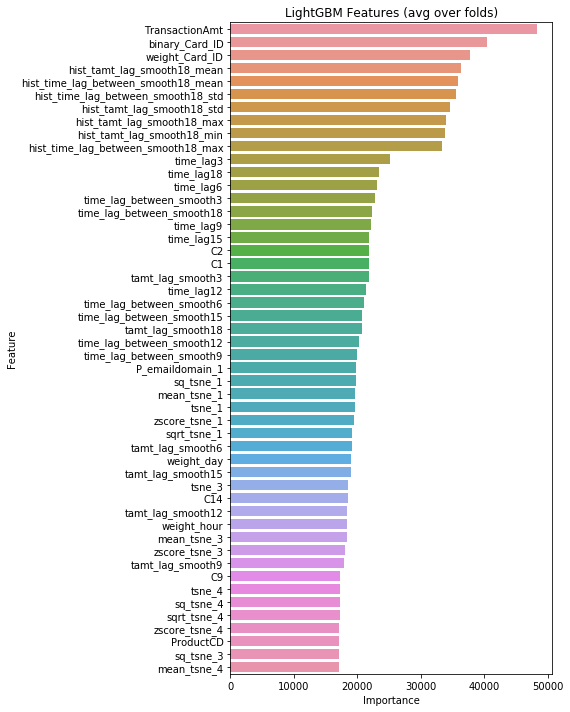

In [63]:
display_importances(features_importance)

Submit predictions

In [64]:
sample_submission = pd.DataFrame()
sample_submission['TransactionID'] = test['TransactionID']
sample_submission['isFraud'] = test_predictions
sample_submission.to_csv(WDR + 'time_series_attempt_01.csv', index=False)